# Modelling

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression as LR
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report, accuracy_score
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_json('data/data.json')

In [3]:
df.shape

(14337, 44)

### Feature Engineering

**Target : fraud**

In [4]:
def make_target(df):
    output = ['fraud' in val for val in df['acct_type']]
    return output

In [5]:
y = make_target(df) 

**NLP : description**

We have a lot of useless html information here. We will parse those out in order to have a cleaner description.

In [6]:
df.description[0][0:500]

'<p><a href="http://s432.photobucket.com/albums/qq49/digusonline/?action=view&amp;current=supersunday.jpg" target="_blank"><img src="http://i432.photobucket.com/albums/qq49/digusonline/supersunday.jpg" border="0" alt="Photobucket" /></a></p>\r\n<p>\xa0</p>\r\n<p style="text-align: center;"><font size="3"><strong>Party Starz Entertaintment &amp; Diverse International Group Presents...<br /></strong></font><br /><font face="tahoma,arial,helvetica,sans-serif" size="4"><strong>The Official\xa0"99 Hour No Sleep'

Following code:

- creates an empty list.
- soups each description with html.parser
- appends parced descriptions to the list called parced
- loads the new parced descriptions to df.descrption

In [7]:
parsed = []
for html in df.description.values:
    soup = BeautifulSoup(html, 'html.parser')
    parsed.append(soup.text)
#overwrite html with clean text
df['description'] = parsed

You may see a description example without html at following. It worked.

In [8]:
df.description[0][0:500]

'\n\xa0\nParty Starz Entertaintment & Diverse International Group Presents...The Official\xa0"99 Hour No Sleep" Super Bowl \nWeekend Grand Finale\nNo matter who wins or loses, this post-game party cannot be missed! Enjoy the drink specials and all night music!\xa0The ultimate "99 No Sleep"\xa0Super Bowl Weekend Grand Finale! Sunday, February 7th, 2010 @ Ink Nightclub-South Beach (717 Washington Ave, Miami Bch, FL 33139).\nHosted by 99 Jamz with special appearances by Fast Life Youngstaz. Special invited guests: B'

**This one goes for Dummy features**

In [9]:
def dummy(df, col):
    ''' Function does not update df inplace 
    input:
    df (dataframe)
    col (string)
    '''
    dummies = pd.get_dummies(df[col], prefix=col)
    return df.drop(col, axis=1).merge(dummies, left_index=True, right_index=True)

**Get the Right Features**

Seting the features that I will involve in my analisis in a list.

In [10]:
features = ['user_age', 'country', 
                  'ticket_types', 'venue_address', 'channels', 
                  'has_logo', 'delivery_method']

Get the dataframe, features you want to involve and features you want to dummy.

Return the output dataframe only with those features and the ones that dummied.

In [11]:
def extract_features(df, col_wanted, col_dummies_needed):
    #df = pd.read_json(path)
    output_df = df[col_wanted]
    for col in col_dummies_needed:
        output_df = dummy(output_df, col)
    return output_df

In [12]:
df_test = extract_features(df, features, ['delivery_method', 'country'])

In [13]:
df.columns

Index(['acct_type', 'approx_payout_date', 'body_length', 'channels', 'country',
       'currency', 'delivery_method', 'description', 'email_domain',
       'event_created', 'event_end', 'event_published', 'event_start',
       'fb_published', 'gts', 'has_analytics', 'has_header', 'has_logo',
       'listed', 'name', 'name_length', 'num_order', 'num_payouts',
       'object_id', 'org_desc', 'org_facebook', 'org_name', 'org_twitter',
       'payee_name', 'payout_type', 'previous_payouts', 'sale_duration',
       'sale_duration2', 'show_map', 'ticket_types', 'user_age',
       'user_created', 'user_type', 'venue_address', 'venue_country',
       'venue_latitude', 'venue_longitude', 'venue_name', 'venue_state'],
      dtype='object')

In [14]:
df_test.columns

Index(['user_age', 'ticket_types', 'venue_address', 'channels', 'has_logo',
       'delivery_method_0.0', 'delivery_method_1.0', 'delivery_method_3.0',
       'country_', 'country_A1', 'country_AE', 'country_AR', 'country_AT',
       'country_AU', 'country_BB', 'country_BE', 'country_BG', 'country_BS',
       'country_CA', 'country_CH', 'country_CI', 'country_CM', 'country_CN',
       'country_CO', 'country_CR', 'country_CZ', 'country_DE', 'country_DK',
       'country_DZ', 'country_EC', 'country_ES', 'country_FI', 'country_FR',
       'country_GB', 'country_GH', 'country_GR', 'country_HR', 'country_HU',
       'country_ID', 'country_IE', 'country_IL', 'country_IM', 'country_IN',
       'country_IS', 'country_IT', 'country_JE', 'country_JM', 'country_KE',
       'country_KH', 'country_LB', 'country_MA', 'country_MX', 'country_MY',
       'country_NA', 'country_NG', 'country_NI', 'country_NL', 'country_NZ',
       'country_PE', 'country_PH', 'country_PK', 'country_PR', 'country_PS',
   

Can number of ticket types provided per event be a fine predictor? We will find it out.

- Gets the # of ticket types provided per event and appends tgem in a list.
- Drops ticket type column
- Adds a new column called ticket_type_lenght
- returns new df


In [15]:
def extract_ticket_tiers(df):
    '''
    output df will drop ticket_types col
    '''
    ticket_types_length = []
    for ticket_type in df['ticket_types'].values:
        ticket_types_length.append(len(ticket_type))
    output_df = df.drop('ticket_types', axis=1)
    output_df['ticket_type_length'] = ticket_types_length
    return output_df

In [16]:
df_test = extract_ticket_tiers(df_test)

In [17]:
df_test.ticket_type_length[0:5]

0    3
1    2
2    1
3    6
4    8
Name: ticket_type_length, dtype: int64

Maybe fake events doesn't have an adress! Can it be true?

- set a mask, if the venue address is empty string it is True, else it is False
- create a new feature called no_address and values are equavalent to that of mask
- map: if True return 0 if False return 1 (you see the little rebel in me now don't you)
- we don't need vanue address anymore so get rid of it eh?

In [18]:
def extract_venue_address_given(df):
    mask = df['venue_address'] == ''
    df['no_address'] = mask
    df['no_address'] =  df['no_address'].map({True:0, False:1})
    X = df.drop('venue_address', axis=1)
    return X

In [19]:
X = extract_venue_address_given(df_test)

In [20]:
X.no_address.head()

0    1
1    0
2    1
3    0
4    1
Name: no_address, dtype: int64

### Arange the features

In [21]:
#save column names
cols = sorted(list(X.columns.values))

#sort features
#sort X
new_df = pd.DataFrame()
for col in sorted(X.columns):
    new_df[col] = X[col]
X = new_df
cols.insert(0, 'description')

X['description'] = parsed
X = X[cols]

print(X.columns)

Index(['description', 'channels', 'country_', 'country_A1', 'country_AE',
       'country_AR', 'country_AT', 'country_AU', 'country_BB', 'country_BE',
       'country_BG', 'country_BS', 'country_CA', 'country_CH', 'country_CI',
       'country_CM', 'country_CN', 'country_CO', 'country_CR', 'country_CZ',
       'country_DE', 'country_DK', 'country_DZ', 'country_EC', 'country_ES',
       'country_FI', 'country_FR', 'country_GB', 'country_GH', 'country_GR',
       'country_HR', 'country_HU', 'country_ID', 'country_IE', 'country_IL',
       'country_IM', 'country_IN', 'country_IS', 'country_IT', 'country_JE',
       'country_JM', 'country_KE', 'country_KH', 'country_LB', 'country_MA',
       'country_MX', 'country_MY', 'country_NA', 'country_NG', 'country_NI',
       'country_NL', 'country_NZ', 'country_PE', 'country_PH', 'country_PK',
       'country_PR', 'country_PS', 'country_PT', 'country_QA', 'country_RO',
       'country_RS', 'country_RU', 'country_SE', 'country_SG', 'country_SI',
  

### Train Test Split

In [32]:
XX = X.values

In [33]:
X_train, X_test, y_train, y_test = train_test_split(XX, y, test_size=0.2, random_state=915)

### Pipeline

In [22]:
import pickle
import class_opens_pickle
from class_opens_pickle import Foo 

**NLP that description**

In [27]:
snowball = SnowballStemmer('english')

def tokenize(doc):
    return [snowball.stem(word) for word in word_tokenize(doc.lower())]



class NLP:
    def __init__(self):
        self.tfidf = TfidfVectorizer(stop_words='english', tokenizer=tokenize, max_features=1000)
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        self.tfidf.fit(X[:,0])
        return self
        
    def transform(self, X):
        text_data = self.tfidf.transform(X[:,0])
        text_data = text_data.toarray()
        return np.concatenate((X[:,1:], text_data), axis=1)

**Opening the pipeline model**

In [34]:
if __name__=='__main__':
    class_opens_pickle.main() # Objects are being pickled with main_module as the top-level
    with open('dumb_model.pkl', 'rb') as f:
        final_pipeline = pickle.load(f)

In [35]:
final_pipeline

Pipeline(memory=None,
     steps=[('NLP', <__main__.NLP object at 0x1abb4ca5c0>), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

**Get Probabilities and predictions.**

In [36]:
probs = final_pipeline.predict_proba(X_test)

In [37]:
y_prob = probs[:, 1]

In [38]:
y_prob

array([0.038, 0.004, 0.035, ..., 0.633, 0.015, 0.025])

In [39]:
y_pred = final_pipeline.predict(X_test)

In [40]:
y_pred

array([False, False, False, ...,  True, False, False])

**Model Performance: Classification Report**

In [41]:
# Find accuracy of hold-out test
print(classification_report(y_test, y_pred))
print('\nAccuracy Score: {:.2f}'.format(accuracy_score(y_test, y_pred)))

              precision    recall  f1-score   support

       False       0.95      0.99      0.97      2610
        True       0.89      0.44      0.59       258

   micro avg       0.94      0.94      0.94      2868
   macro avg       0.92      0.72      0.78      2868
weighted avg       0.94      0.94      0.94      2868


Accuracy Score: 0.94


Not bad! Yet think about ways to increase that recall score for positive predictions.

**Model Performance: ROC Curve & AUC**

In [42]:
from sklearn.metrics import auc, roc_curve

In [43]:
def plot_roc(fpr, tpr, auc_score):
    plt.figure(figsize=(6, 6))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, 'b', label='ROC score = {:5.2f}'.format(auc_score))
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.01,1.01])
    plt.ylim([-0.01,1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return

In [44]:
y_prob[:10]

array([0.038     , 0.004     , 0.035     , 0.023     , 0.015     ,
       0.066     , 0.90525079, 0.11      , 0.032     , 0.092     ])

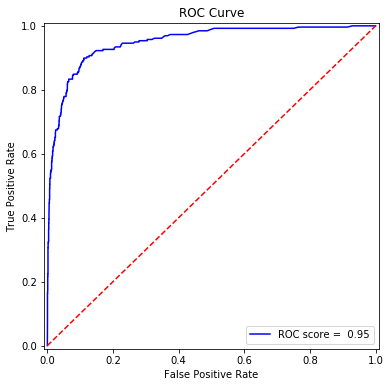

In [45]:
# Compute ROC and AUC
fpr, tpr, thresholds = roc_curve(y_true= y_test, y_score=y_prob)
auc_score = auc(fpr, tpr)
roc_score = roc_auc_score(y_test,y_prob)

plot_roc(fpr, tpr, roc_score)

In [46]:
roc_score

0.9500155929787044

## Profit Curve

Lets see how much money we will save.

**Tresholds:** Used to compare probabilities with.

In [49]:
treshholds = np.linspace(0,1,100)

### Cost Benefit Matrix

Throwback to findings from step_2_EDA.

- Total number of fraud events: 1293

- Avg Cost of all fraud events: $ 461

- Total number of fraud events that harm the company: 329 (2.2%)

- Avg. Cost of fraud events that harm the company: $ 1815

- Avg. Revenue per valid customer: $ 2885.

**False Positive Reaction Assumptions:**
- The company will lose 0.01 of all customer which bothered with FP actions
- Reacting to positive predictions costs the company $ 10 each(sending emails, calling customers etc.)

**Cost_Benefit Matrix Baseline:** Do not reach if model predicts negative for fraud. Anyways those events are real and there is nothing to fix!

In [52]:
avg_cost_of_fraud = 461.7
avg_revenue_per_valid_customer = 2823.75

**Inputs**
- tp = amount of money the model saves us by predicting fraud - cost of reacting to fraud event
- fn = 0 because baseline for negative predictions is to do nothing.
- fp = - cost of reacting to fraud event - lost revenue due to bothering customer * the ratio of customers that are bothered
- tn = 0 because baseline for negative predictions is to do nothing.

Hint: We build cost benefit matrices to measure the profitwise effect of machine learning to the business. In accordance to business plan and senario the company only wants to predict fraud in order to prevent unnecessary costs. Thats why I am  only measuring the financial value saved with positive predictions(positive == fraud).


In [53]:
tp = avg_cost_of_fraud - 10
fn = 0 
fp = -10 - avg_revenue_per_valid_customer * 0.01 
tn = 0


cost_mat = np.array([[tp, fn], [fp, tn]])
cost_mat

array([[451.7   ,   0.    ],
       [-38.2375,   0.    ]])

Compare y_prob to each treshold within linnear space of 0 to 100 in order to find the profit maximizing treshold.

In [54]:
expected_total_profit = []
for t in treshholds:
    predictions = (y_prob > t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    conf_mat = np.array([[tp, fn], [fp, tn]])
    expected_total_profit.append((conf_mat * cost_mat).sum())

argsort --> sorts the values and returns the indeces. we get the final index because thats the highest!

In [55]:
maximum_expected_profit_index = np.argsort(np.array(expected_total_profit))[-1]

In [58]:
maximum_expected_profit_index

10

Remember we have a list of expected total profits.

In [63]:
expected_total_profit[0:15] #actual lenght is 100.

[6.782980299860528,
 12.371774755927476,
 18.560529986052998,
 23.058555613668062,
 26.212495641562064,
 28.15816771269177,
 29.829711471408647,
 30.73046548117155,
 31.59122210599721,
 32.13449267782427,
 32.48612273361227,
 32.165276324965134,
 31.422777196652717,
 31.587752789400273,
 31.528569560669457]

Yet only one of them is the maximized profit, which corresponds to index number 10 due to argsort.

In [64]:
expected_total_profit[maximum_expected_profit_index]

32.48612273361227

The Profit Curve whih plots expected profit for each treshold and highligting profit maximizing treshold.

Threshold that gives the highest expected profit:0.10101010101010102


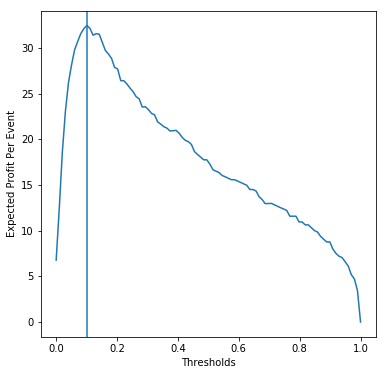

In [65]:
plt.figure(figsize=(6,6))
plt.plot(treshholds, expected_total_profit, label='XGBoost Classifier')
plt.xlabel('Thresholds')
plt.ylabel('Expected Profit Per Event')
plt.axvline(treshholds[maximum_expected_profit_index])
print(f'Threshold that gives the highest expected profit:{treshholds[maximum_expected_profit_index]}')

**Conclusion:** The Model saves $ 32.48 per event. 